In [1]:
# For version check
from platform import python_version
from importlib.metadata import version

In [2]:
import re
import math

import numpy as np
import pandas as pd
import seaborn as sns
import pylab as plt

import networkx as nx
import Bio
import mygene

In [3]:
print('Python: ', python_version())

print('numpy: ', version('numpy'))
print('pandas: ', pd.__version__)
print('seaborn: ', version('seaborn'))
print('matplotlib: ', version('matplotlib'))

print('networkx: ', nx.__version__)
print('Biopython: ', version('Biopython'))
print('MyGene: ', version('mygene'))

Python:  3.10.1
numpy:  1.22.3
pandas:  1.4.2
seaborn:  0.11.2
matplotlib:  3.5.2
networkx:  2.8.5
Biopython:  1.79
MyGene:  3.2.2


Python:  3.10.1

numpy:  1.22.3\
pandas:  1.4.2\
seaborn:  0.11.2\
matplotlib:  3.5.2\
networkx:  2.8.1\
Biopython:  1.79

# GenOrigin

The gene ages calculated from the protein ages gave different results for human and mouse and yeast GRNs. We decided to use the gene ages from the GenOrigin database for calculations.


## Contents:
1. [Yeast GRN](#Yeast).\
   1.1. [Load and transfrom numbers to classes](#Yeast_load).\
   1.2. [Heatmap](#Yeast_heatmap).\
   1.3. [Edge "len"](#Yeast_len).
2. [Mouse GRN](#Mouse).\
   2.1. [Load and transfrom numbers to classes](#Mouse_load).\
   2.2. [Heatmap](#Mouse_heatmap).\
   2.3. [Edge "len"](#Mouse_len).
2. [Human GRN](#Mouse).\
   2.1. [Load and transfrom numbers to classes](#Human_load).\
   2.2. [Heatmap](#Human_heatmap).\
   2.3. [Edge "len"](#Human_len).

In [4]:
# load GRNs:

# yeast
yeast_data = pd.read_csv('../data/01_GRNs/yeast.txt', sep='\t')
yeast_graph = nx.from_pandas_edgelist(yeast_data, source='Tf', target='Tg', 
                                      create_using=nx.DiGraph())

# mouse
mouse_data = pd.read_csv('../data/01_GRNs/trrust_rawdata.mouse.tsv', 
                         sep='\t', header=None, 
                         names=['TF', 'Target', 'Mode', 'PMID'])
mouse_graph = nx.from_pandas_edgelist(mouse_data, 'TF', 'Target', ['Mode', 'PMID'], 
                                      create_using=nx.DiGraph())

# human
human_data = pd.read_csv('../data/01_GRNs/trrust_rawdata.human.tsv', 
                         sep='\t', header=None, 
                         names=['TF', 'Target', 'Mode', 'PMID'])
human_graph = nx.from_pandas_edgelist(human_data, 'TF', 'Target', ['Mode', 'PMID'], 
                                      create_using=nx.DiGraph())

# 1. Yeast GRN <a name="Yeast"></a>
 
## 1.1. Load and transfrom numbers to classes <a name="Yeast_load"></a>

In [47]:
yeast_gen_ages = pd.read_csv('../data/03_GenOrigin/Saccharomyces_cerevisiae.csv')

#rename for mapping
yeast_gen_ages. rename(columns = {'ensembl_id':'Tf'}, inplace = True)

In [48]:
# tranform numbers to classes using GenOrigin tree

yeast_gen_ages['gene_age'] = yeast_gen_ages['gene_age'].apply(lambda x: 4290 if x == '>4290' else x)
yeast_gen_ages["gene_age"] = pd.to_numeric(yeast_gen_ages["gene_age"])

In [8]:
yeast_gen_ages['distance'] = np.where(yeast_gen_ages['gene_age'] <= 69,
                                      'Saccharomyces',
                                      yeast_gen_ages['gene_age'])

yeast_gen_ages['distance'] = np.where((yeast_gen_ages['gene_age'] <= 212) & (yeast_gen_ages['gene_age'] > 69),
                                      'Saccharomycetaceae',
                                      yeast_gen_ages['distance'])

yeast_gen_ages['distance'] = np.where((yeast_gen_ages['gene_age'] <= 590) & (yeast_gen_ages['gene_age'] > 212),
                                      'Saccharomyceta',
                                      yeast_gen_ages['distance'])

yeast_gen_ages['distance'] = np.where((yeast_gen_ages['gene_age'] <= 723) & (yeast_gen_ages['gene_age'] > 590),
                                      'Ascomycota',
                                      yeast_gen_ages['distance'])

yeast_gen_ages['distance'] = np.where((yeast_gen_ages['gene_age'] <= 817) & (yeast_gen_ages['gene_age'] > 723),
                                      'Dikarya',
                                      yeast_gen_ages['distance'])

yeast_gen_ages['distance'] = np.where((yeast_gen_ages['gene_age'] <= 1105) & (yeast_gen_ages['gene_age'] > 817),
                                      'Fungi',
                                      yeast_gen_ages['distance'])

yeast_gen_ages['distance'] = np.where((yeast_gen_ages['gene_age'] <= 1480) & (yeast_gen_ages['gene_age'] > 1105),
                                      'Opisthokonta',
                                      yeast_gen_ages['distance'])

yeast_gen_ages['distance'] = np.where((yeast_gen_ages['gene_age'] <= 2101) & (yeast_gen_ages['gene_age'] > 1480),
                                      'Eukaryota',
                                      yeast_gen_ages['distance'])

yeast_gen_ages['distance'] = np.where((yeast_gen_ages['gene_age'] <= 4290) & (yeast_gen_ages['gene_age'] > 2101),
                                      '> Eukaryota',
                                      yeast_gen_ages['distance'])

In [9]:
# results

print(yeast_gen_ages.shape)
yeast_gen_ages.head()

(6600, 4)


,Tf,gene_age,gene_Interval,distance
0,YDR301W,34,0-69,Saccharomyces
1,YDR302W,34,0-69,Saccharomyces
2,YDR303C,163,114-212,Saccharomycetaceae
3,YDR304C,1488,1480-1496,Eukaryota
4,YDR305C,1488,1480-1496,Eukaryota


In [10]:
yest_TFTG = set(list(yeast_data.Tf) + list(yeast_data.Tg))
yeast_gene_ages = yeast_gen_ages.query('Tf in @yest_TFTG')
print(yeast_gene_ages.shape)

(4185, 4)


In [20]:
# save to csv
yeast_gene_ages[['Tf', 'distance']].to_csv('../data/03_GenOrigin/yeast_gene_ages_GO.csv', index=False)

In [11]:
# Class distribution
yeast_sum_ages = yeast_gene_ages.groupby('distance', as_index=0).count()[['distance', 'Tf']]
yeast_sum_ages.loc["Total"] = yeast_sum_ages.sum()
yeast_sum_ages.loc['Total', 'distance'] = 'Total'
yeast_sum_ages.rename(columns = {'distance':'Age class', 'Tf': 'Genes number'}, inplace = True)
yeast_sum_ages

,Age class,Genes number
0,> Eukaryota,332
1,Ascomycota,950
2,Dikarya,213
3,Eukaryota,539
4,Fungi,463
5,Opisthokonta,81
6,Saccharomyces,688
7,Saccharomyceta,445
8,Saccharomycetaceae,474
Total,Total,4185


In [12]:
# mapping
yeast_data['Tf_age'] = yeast_data.merge(yeast_gen_ages, how='left', on=['Tf']).distance

yeast_gen_ages. rename(columns = {'Tf':'Tg'}, inplace = True)
yeast_data['Tg_age'] = yeast_data.merge(yeast_gen_ages, how='left', on=['Tg']).distance

In [13]:
yeast_data.head()

,Tf,Tg,Tf_age,Tg_age
0,YAL051W,YAL016W,Saccharomycetaceae,Fungi
1,YAL051W,YAL034WA,Saccharomycetaceae,NaN
2,YAL051W,YAL035CA,Saccharomycetaceae,NaN
3,YAL051W,YAL035W,Saccharomycetaceae,> Eukaryota
4,YAL051W,YAL036C,Saccharomycetaceae,> Eukaryota


In [15]:
yeast_data.to_csv('../data/03_GenOrigin/yeast_classes_GO.csv', index=False)

## 1.2. Heatmap <a name="Yeast_heatmap"></a>

In [31]:
# Substituting nans with "no info"
yeast_data[['Tg_age', 'Tf_age']] = yeast_data[['Tg_age', 'Tf_age']].replace(np.nan, 'no info')

In [32]:
heatmap_y = pd.crosstab(yeast_data.Tf_age, yeast_data.Tg_age, normalize=True)
heatmap_y

Tg_age,> Eukaryota,Ascomycota,Dikarya,Eukaryota,Fungi,Opisthokonta,Saccharomyces,Saccharomyceta,Saccharomycetaceae,no info
Tf_age,,,,,,,,,,
> Eukaryota,0.004039,0.010099,0.001554,0.006059,0.004039,0.000699,0.004428,0.004428,0.003729,0.002641
Ascomycota,0.016313,0.046765,0.010409,0.026490,0.020275,0.002797,0.035035,0.023072,0.028587,0.011730
Dikarya,0.000311,0.000621,0.000155,0.000932,0.000855,0.000078,0.001942,0.000932,0.001942,0.000621
Eukaryota,0.005671,0.014527,0.003806,0.006448,0.006448,0.000932,0.012507,0.007691,0.008778,0.004195
Fungi,0.009166,0.038453,0.006758,0.018100,0.018022,0.002175,0.034025,0.019420,0.021596,0.014527
Opisthokonta,0.004350,0.012429,0.002719,0.006448,0.006137,0.000932,0.008933,0.005282,0.005593,0.002175
Saccharomyces,0.005438,0.016857,0.002719,0.008700,0.006836,0.000932,0.016236,0.007147,0.010332,0.004583
Saccharomyceta,0.012662,0.029286,0.008545,0.018178,0.015614,0.002486,0.025946,0.016546,0.016391,0.008234
Saccharomycetaceae,0.010254,0.038608,0.007613,0.019187,0.015226,0.001476,0.035811,0.020819,0.024625,0.012662


Text(0.5, 1.0, 'Age classes heatmap, yeast (GenOrigin)')

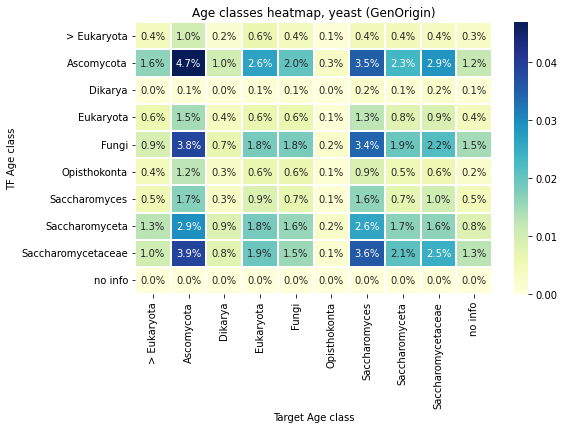

In [36]:
plt.rcParams["figure.figsize"] = 8, 5


x_axis_labels = ['> Eukaryota', 'Ascomycota', 'Dikarya', 'Eukaryota', 'Fungi', 'Opisthokonta', 
                 'Saccharomyces', 'Saccharomyceta','Saccharomycetaceae', 'no info']

y_axis_labels = ['> Eukaryota', 'Ascomycota', 'Dikarya', 'Eukaryota', 'Fungi', 'Opisthokonta', 
                 'Saccharomyces', 'Saccharomyceta','Saccharomycetaceae', 'no info']

s = sns.heatmap(heatmap_y,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".1%",
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
plt.title('Age classes heatmap, yeast (GenOrigin)')

#plt.savefig('../data/03_plots/yeast_heatmap_01.png')
#plt.close()

#### Tg/TF

In [19]:
ages_list = ['no info', '> Eukaryota', 'Eukaryota', 'Opisthokonta', 'Fungi', 'Dikarya', 'Ascomycota', 
            'Saccharomyceta', 'Saccharomycetaceae', 'Saccharomyces']
tf_tg_count = heatmap_y.copy()

for tf_age in ages_list:
    for tg_age in ages_list:
        new_table = yeast_data[(yeast_data.Tg_age == tg_age) & (yeast_data.Tf_age == tf_age)]
        if new_table[['Tf']].nunique().iloc[0] != 0:
            new_value = new_table[['Tg']].nunique().iloc[0] / new_table[['Tf']].nunique().iloc[0]
        else:
            new_value = 0
        tf_tg_count.loc[tf_age, tg_age] = new_value

In [20]:
tf_tg_count

Tg_age,> Eukaryota,Ascomycota,Dikarya,Eukaryota,Fungi,Opisthokonta,Saccharomyces,Saccharomyceta,Saccharomycetaceae,no info
Tf_age,,,,,,,,,,
> Eukaryota,9.800000,25.000000,5.000000,15.600000,12.500000,4.500000,11.000000,11.400000,9.400000,6.800000
Ascomycota,6.250000,15.576923,3.909091,9.791667,7.076923,2.307692,10.185185,7.760000,8.538462,3.500000
Dikarya,1.333333,4.000000,1.000000,2.400000,2.000000,1.000000,5.500000,2.500000,4.000000,2.666667
Eukaryota,6.900000,14.454545,5.000000,6.909091,8.555556,1.833333,13.200000,7.800000,8.636364,4.300000
Fungi,5.277778,17.190476,4.117647,8.000000,8.842105,2.545455,13.136364,8.428571,9.750000,6.300000
Opisthokonta,10.600000,31.400000,6.800000,15.600000,15.400000,2.750000,21.800000,12.400000,13.800000,7.000000
Saccharomyces,5.083333,14.846154,3.200000,7.285714,6.750000,3.000000,10.000000,5.928571,6.250000,4.000000
Saccharomyceta,6.000000,12.727273,4.500000,7.739130,7.400000,2.000000,9.782609,5.600000,5.440000,3.888889
Saccharomycetaceae,4.727273,11.896552,3.523810,6.357143,5.538462,1.357143,9.965517,7.166667,6.785714,4.107143


In [21]:
tf_ages_count = yeast_data.groupby(['Tf', 'Tf_age'], as_index=0).count().groupby('Tf_age', as_index=0).count()[['Tf_age', 'Tf']]
tg_ages_count = yeast_data.groupby(['Tg', 'Tg_age'], as_index=0).count().groupby('Tg_age', as_index=0).count()[['Tg_age', 'Tg']]

Text(0.5, 1.0, 'TG/TF heatmap, yeast (GenOrigin)')

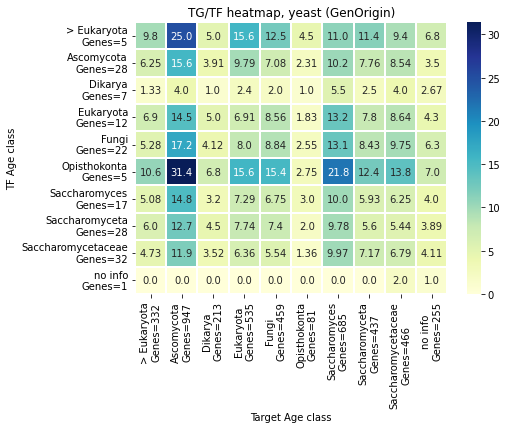

In [40]:
plt.rcParams["figure.figsize"] = 7, 5

xlabels = ['> Eukaryota', 'Ascomycota', 'Dikarya', 'Eukaryota', 'Fungi', 'Opisthokonta', 
           'Saccharomyces', 'Saccharomyceta','Saccharomycetaceae', 'no info']

ylabels = ['> Eukaryota', 'Ascomycota', 'Dikarya', 'Eukaryota', 'Fungi', 'Opisthokonta', 
           'Saccharomyces', 'Saccharomyceta','Saccharomycetaceae', 'no info']
    
x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    x_axis_labels.append(f'{label}\nGenes={tg_ages_count[tg_ages_count.Tg_age == label].Tg.iloc[0]}')

    
for label in ylabels:
    y_axis_labels.append(f'{label}\nGenes={tf_ages_count[tf_ages_count.Tf_age == label].Tf.iloc[0]}')

s = sns.heatmap(tf_tg_count,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".3",
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
plt.title('TG/TF heatmap, yeast (GenOrigin)')

#plt.savefig('../data/03_plots/yeast_heatmap_02.png')
#plt.close()

## 1.3. Edge "len"  <a name="Yeast_len"></a>

In [43]:
classes = ['no info', '> Eukaryota', 'Eukaryota', 'Opisthokonta', 'Fungi', 'Dikarya', 'Ascomycota', 
           'Saccharomyceta', 'Saccharomycetaceae', 'Saccharomyces']

yeast_data['Tg_age'] = yeast_data['Tg_age'].apply(lambda x: classes.index(x))
yeast_data['Tf_age'] = yeast_data['Tf_age'].apply(lambda x: classes.index(x))

In [44]:
yeast_data['age_length'] = np.where((yeast_data['Tf_age'] == 0) | (yeast_data['Tg_age'] == 0),
                                     -1,
                                     abs(yeast_data['Tf_age'] - yeast_data['Tg_age']))

# no info to NAN
yeast_data['age_length'] = yeast_data['age_length'].replace({-1: np.nan})

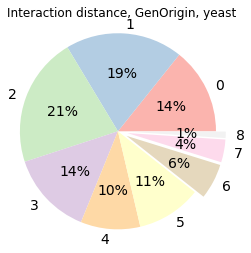

In [48]:
plt.rcParams["figure.figsize"] = 4, 4

idx = [0, 1, 2, 3, 4, 5, 6, 7, 8]
counts = pd.Series(yeast_data['age_length'].value_counts(normalize=True) * 100)
counts.index = counts.index.astype('int64')
counts = counts[idx]

explode = (0, 0, 0, 0, 0, 0, 0.1, 0.1, 0.1)
counts.plot(kind='pie', 
            fontsize=14, 
            colormap="Pastel1", 
            explode=explode,  
            autopct='%.0f%%')
plt.axis('equal')
plt.ylabel('')
plt.title('Interaction distance, GenOrigin, yeast')

plt.show()
#plt.savefig('../data/03_plots/yeast_len.png')
#plt.close()

# 2. Mouse GRN <a name="Mouse"></a>
 
## 2.1. Load and transfrom numbers to classes <a name="Mouse_load"></a>

In [5]:
mouse_gen_ages = pd.read_csv('../data/03_GenOrigin/Mus_musculus.csv')

In [113]:
# transform ensemb_id to gene name
mg = mygene.MyGeneInfo()
mouse_id_list = list(mouse_gen_ages['ensembl_id'])

results = mg.querymany(mouse_id_list, scopes='ensembl.gene', fields='symbol', species='mouse')

with open("../data/03_GenOrigin/Mus_musculus_id_gene.csv", "a") as file:
    file.write('ensembl_id,gene\n')
    for res in results:
        if 'symbol' in res:
            file.write(f'{res["query"]},{res["symbol"]}\n')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-22832...done.
Finished.
2 input query terms found dup hits:
	[('ENSMUSG00000094475', 2), ('ENSMUSG00000029723', 3)]
405 input query terms found no hit:
	['ENSMUSG00000096646', 'ENSMUSG00000079774', 'ENSMUSG00000095207', 'ENSMUSG00000094576', 'ENSMUSG000
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [6]:
mouse_id_to_genes = pd.read_csv('../data/03_GenOrigin/Mus_musculus_id_gene.csv')

mouse_gen_ages['Tf'] = mouse_gen_ages.merge(mouse_id_to_genes, how='left', on=['ensembl_id']).gene

In [7]:
# tranform numbers to classes using GenOrigin tree
mouse_gen_ages['gene_age'] = mouse_gen_ages['gene_age'].apply(lambda x: 4290 if x == '>4290' else x)
mouse_gen_ages["gene_age"] = pd.to_numeric(mouse_gen_ages["gene_age"])

In [8]:
mouse_gen_ages['distance'] = np.where(mouse_gen_ages['gene_age'] <= 33,
                                      'Muridae',
                                      mouse_gen_ages['gene_age'])

mouse_gen_ages['distance'] = np.where((mouse_gen_ages['gene_age'] <= 82) & (mouse_gen_ages['gene_age'] > 33),
                                      'Rodentia',
                                      mouse_gen_ages['distance'])

mouse_gen_ages['distance'] = np.where((mouse_gen_ages['gene_age'] <= 312) & (mouse_gen_ages['gene_age'] > 82),
                                      'Mammalia',
                                      mouse_gen_ages['distance'])

mouse_gen_ages['distance'] = np.where((mouse_gen_ages['gene_age'] <= 352) & (mouse_gen_ages['gene_age'] > 312),
                                      'Amniota',
                                      mouse_gen_ages['distance'])

mouse_gen_ages['distance'] = np.where((mouse_gen_ages['gene_age'] <= 676) & (mouse_gen_ages['gene_age'] > 352),
                                      'Vertebrata',
                                      mouse_gen_ages['distance'])

mouse_gen_ages['distance'] = np.where((mouse_gen_ages['gene_age'] <= 948) & (mouse_gen_ages['gene_age'] > 676),
                                      'Eumetazoa',
                                      mouse_gen_ages['distance'])

mouse_gen_ages['distance'] = np.where((mouse_gen_ages['gene_age'] <= 1480) & (mouse_gen_ages['gene_age'] > 948),
                                      'Opisthokonta',
                                      mouse_gen_ages['distance'])

mouse_gen_ages['distance'] = np.where((mouse_gen_ages['gene_age'] <= 2101) & (mouse_gen_ages['gene_age'] > 1480),
                                      'Eukaryota',
                                      mouse_gen_ages['distance'])

mouse_gen_ages['distance'] = np.where((mouse_gen_ages['gene_age'] <= 4290) & (mouse_gen_ages['gene_age'] > 2101),
                                      '> Eukaryota',
                                      mouse_gen_ages['distance'])

In [9]:
# results
print(mouse_gen_ages.shape)
mouse_gen_ages.head()

(22832, 5)


,ensembl_id,gene_age,gene_Interval,Tf,distance
0,ENSMUSG00000095845,101,96-105,Gng14,Mammalia
1,ENSMUSG00000060038,101,96-105,Dhps,Mammalia
2,ENSMUSG00000020864,645,615-676,Ankrd40,Vertebrata
3,ENSMUSG00000094091,39,33-45,Ankrd40cl,Rodentia
4,ENSMUSG00000020863,1578,1496-1660,Luc7l3,Eukaryota


In [10]:
mouse_TFTG = set(list(mouse_data.TF) + list(mouse_data.Target))
mouse_gene_ages = mouse_gen_ages.query('Tf in @mouse_TFTG')
print(mouse_gene_ages.shape)

(2401, 5)


In [119]:
# save to csv
mouse_gene_ages[['Tf', 'distance']].to_csv('../data/03_GenOrigin/mouse_gene_ages_GO.csv', index=False)

In [11]:
# Class distribution
mouse_sum_ages = mouse_gene_ages.groupby('distance', as_index=0).count()[['distance', 'Tf']]
mouse_sum_ages.loc["Total"] = mouse_sum_ages.sum()
mouse_sum_ages.loc['Total', 'distance'] = 'Total'
mouse_sum_ages.rename(columns = {'distance':'Age class', 'Tf': 'Genes number'}, inplace = True)
mouse_sum_ages

,Age class,Genes number
0,> Eukaryota,141
1,Amniota,31
2,Eukaryota,176
3,Eumetazoa,357
4,Mammalia,107
5,Muridae,63
6,Opisthokonta,407
7,Rodentia,65
8,Vertebrata,1054
Total,Total,2401


In [12]:
#rename for mapping
mouse_gen_ages.rename(columns = {'Tf':'TF'}, inplace = True)

In [13]:
# mapping
mouse_data['Tf_age'] = mouse_data.merge(mouse_gen_ages, how='left', on=['TF']).distance

mouse_gen_ages. rename(columns = {'TF':'Target'}, inplace = True)
mouse_data['Tg_age'] = mouse_data.merge(mouse_gen_ages, how='left', on=['Target']).distance

In [14]:
mouse_data.head()

,TF,Target,Mode,PMID,Tf_age,Tg_age
0,Aatf,Bak1,Unknown,22983126,Rodentia,Vertebrata
1,Aatf,Bax,Unknown,22983126,Rodentia,Opisthokonta
2,Aatf,Bbc3,Unknown,22983126,Rodentia,Rodentia
3,Aatf,Cdkn1a,Unknown,21317046,Rodentia,Vertebrata
4,Aatf,Tpt1,Activation,17157788,Rodentia,Vertebrata


In [15]:
mouse_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7051 entries, 0 to 7056
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TF      7051 non-null   object
 1   Target  7051 non-null   object
 2   Mode    7051 non-null   object
 3   PMID    7051 non-null   object
 4   Tf_age  7041 non-null   object
 5   Tg_age  6913 non-null   object
dtypes: object(6)
memory usage: 385.6+ KB


In [125]:
mouse_data.to_csv('../data/03_GenOrigin/mouse_classes_GO.csv', index=False)

## 2.2. Heatmap <a name="Mouse_heatmap"></a>

In [16]:
# Substituting nans with "no info"
mouse_data[['Tg_age', 'Tf_age']] = mouse_data[['Tg_age', 'Tf_age']].replace(np.nan, 'no info')

In [17]:
heatmap_m = pd.crosstab(mouse_data.Tf_age, mouse_data.Tg_age, normalize=True)
heatmap_m

Tg_age,> Eukaryota,Amniota,Eukaryota,Eumetazoa,Mammalia,Muridae,Opisthokonta,Rodentia,Vertebrata,no info
Tf_age,,,,,,,,,,
> Eukaryota,0.000851,0.000425,0.001418,0.002978,0.000993,0.000425,0.003262,0.000425,0.008084,0.000142
Amniota,0.000142,0.000000,0.000142,0.000284,0.000284,0.000000,0.000142,0.000142,0.000567,0.000142
Eukaryota,0.002978,0.000567,0.004822,0.010069,0.002553,0.002127,0.011204,0.001418,0.026096,0.000425
Eumetazoa,0.011488,0.002269,0.011204,0.037583,0.008368,0.003687,0.036307,0.006808,0.094313,0.003971
Mammalia,0.001276,0.000000,0.000851,0.002269,0.000851,0.000142,0.003687,0.000284,0.005815,0.000284
Muridae,0.000000,0.000000,0.000000,0.000567,0.000284,0.000142,0.000709,0.000142,0.001560,0.000142
Opisthokonta,0.007942,0.002411,0.010779,0.031910,0.009644,0.005673,0.030350,0.007233,0.097149,0.006382
Rodentia,0.000142,0.000142,0.000284,0.002127,0.000284,0.000425,0.003404,0.000284,0.007233,0.000000
Vertebrata,0.020990,0.005673,0.024252,0.071479,0.021132,0.010779,0.073181,0.010495,0.210608,0.008084


Text(0.5, 1.0, 'Age classes heatmap, mouse (GenOrigin)')

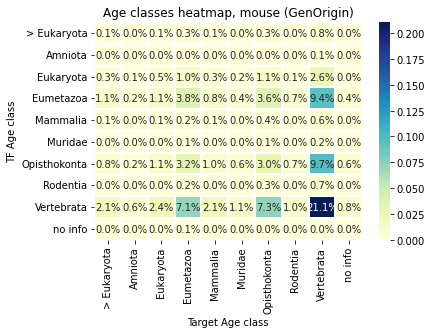

In [18]:
plt.rcParams["figure.figsize"] = 7, 5

x_axis_labels = ['> Eukaryota', 'Amniota', 'Eukaryota', 'Eumetazoa', 'Mammalia', 'Muridae',
                 'Opisthokonta', 'Rodentia','Vertebrata', 'no info']

y_axis_labels = ['> Eukaryota', 'Amniota', 'Eukaryota', 'Eumetazoa', 'Mammalia', 'Muridae',
                 'Opisthokonta', 'Rodentia','Vertebrata', 'no info']

s = sns.heatmap(heatmap_m,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".1%",
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
plt.title('Age classes heatmap, mouse (GenOrigin)')

#plt.savefig('../data/03_plots/mouse_heatmap_01.png')
#plt.close()

#### Tg/TF

In [129]:
ages_list = ['no info', '> Eukaryota', 'Eukaryota', 'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Amniota', 
             'Mammalia', 'Rodentia', 'Muridae']    
    
tf_tg_count = heatmap_m.copy()

for tf_age in ages_list:
    for tg_age in ages_list:
        new_table = mouse_data[(mouse_data.Tg_age == tg_age) & (mouse_data.Tf_age == tf_age)]
        if new_table[['TF']].nunique().iloc[0] != 0:
            new_value = new_table[['Target']].nunique().iloc[0] / new_table[['TF']].nunique().iloc[0]
        else:
            new_value = 0
        tf_tg_count.loc[tf_age, tg_age] = new_value

In [130]:
tf_tg_count

Tg_age,> Eukaryota,Amniota,Eukaryota,Eumetazoa,Mammalia,Muridae,Opisthokonta,Rodentia,Vertebrata,no info
Tf_age,,,,,,,,,,
> Eukaryota,1.000000,2.000000,2.000000,1.500000,1.166667,1.000000,1.666667,1.000000,2.363636,1.000000
Amniota,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000
Eukaryota,1.666667,1.333333,1.454545,2.125000,1.200000,1.071429,2.000000,1.125000,2.136986,1.000000
Eumetazoa,1.825000,1.142857,1.711111,2.483146,1.527778,1.625000,2.127451,1.571429,3.194631,1.350000
Mammalia,1.125000,0.000000,1.500000,1.666667,1.500000,1.000000,1.562500,1.000000,2.222222,1.000000
Muridae,0.000000,0.000000,0.000000,1.333333,1.000000,1.000000,1.000000,1.000000,1.100000,1.000000
Opisthokonta,1.833333,1.416667,1.780488,2.337349,1.500000,1.290323,1.873684,1.600000,2.593583,1.625000
Rodentia,1.000000,1.000000,1.000000,2.500000,1.000000,1.000000,2.555556,1.000000,2.555556,0.000000
Vertebrata,1.534884,1.428571,1.775281,2.096257,1.759494,1.489796,2.026042,1.339623,2.778481,1.571429


In [131]:
tf_ages_count = mouse_data.groupby(['TF', 'Tf_age'], as_index=0).count().groupby('Tf_age', as_index=0).count()[['Tf_age', 'TF']]
tg_ages_count = mouse_data.groupby(['Target', 'Tg_age'], as_index=0).count().groupby('Tg_age', as_index=0).count()[['Tg_age', 'Target']]

Text(0.5, 1.0, 'TG/TF heatmap, mouse (GenOrigin)')

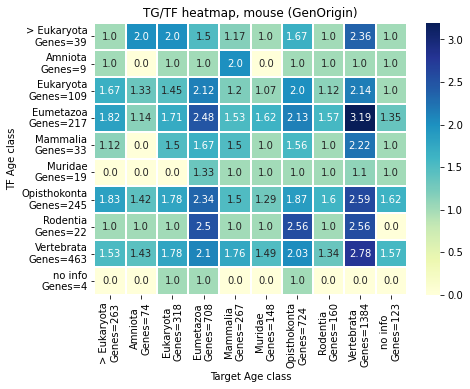

In [134]:
plt.rcParams["figure.figsize"] = 7, 5

xlabels = ['> Eukaryota', 'Amniota', 'Eukaryota', 'Eumetazoa', 'Mammalia', 'Muridae',
           'Opisthokonta', 'Rodentia','Vertebrata', 'no info']
ylabels = ['> Eukaryota', 'Amniota', 'Eukaryota', 'Eumetazoa', 'Mammalia', 'Muridae',
           'Opisthokonta', 'Rodentia','Vertebrata', 'no info']

x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    x_axis_labels.append(f'{label}\nGenes={tg_ages_count[tg_ages_count.Tg_age == label].Target.iloc[0]}')

    
for label in ylabels:
    y_axis_labels.append(f'{label}\nGenes={tf_ages_count[tf_ages_count.Tf_age == label].TF.iloc[0]}')

s = sns.heatmap(tf_tg_count,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".3",
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
plt.title('TG/TF heatmap, mouse (GenOrigin)')

#plt.savefig('../data/03_plots/mouse_heatmap_02.png')
#plt.close()

## 2.3. Edge "len"  <a name="Mouse_len"></a>

In [19]:
classes = ['no info', '> Eukaryota', 'Eukaryota', 'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Amniota', 
           'Mammalia', 'Rodentia', 'Muridae'] 

mouse_data['Tg_age'] = mouse_data['Tg_age'].apply(lambda x: classes.index(x))
mouse_data['Tf_age'] = mouse_data['Tf_age'].apply(lambda x: classes.index(x))

In [20]:
mouse_data['age_length'] = np.where((mouse_data['Tf_age'] == 0) | (mouse_data['Tg_age'] == 0),
                                     -1,
                                     abs(mouse_data['Tf_age'] - mouse_data['Tg_age']))

# no info to NAN
mouse_data['age_length'] = mouse_data['age_length'].replace({-1: np.nan})

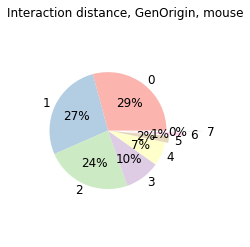

In [51]:
plt.rcParams["figure.figsize"] = 3, 4

idx = [0, 1, 2, 3, 4, 5, 6, 7]
counts = pd.Series(mouse_data['age_length'].value_counts(normalize=True) * 100)
counts.index = counts.index.astype('int64')
counts = counts[idx]

explode = (0, 0, 0, 0, 0, 0.05, 0.3, 0.6)
counts.plot(kind='pie', 
            fontsize=12, 
            colormap="Pastel1", 
            explode=explode,  
            autopct='%.0f%%')
plt.axis('equal')
plt.ylabel('')
plt.title('Interaction distance, GenOrigin, mouse')

plt.show()
#plt.savefig('../data/03_plots/mouse_len.png')
#plt.close()

# 3. Human GRN <a name="Human"></a>
 
## 3.1. Load and transfrom numbers to classes <a name="Human_load"></a>

In [33]:
human_gen_ages = pd.read_csv('../data/03_GenOrigin/Homo_sapiens.csv')

In [32]:
# transform ensemb_id to gene name
mg = mygene.MyGeneInfo()
human_id_list = list(human_gen_ages['ensembl_id'])

results = mg.querymany(human_id_list, scopes='ensembl.gene', fields='symbol', species='human')

with open("../data/03_GenOrigin/Homo_sapiens_id_gene.csv", "a") as file:
    file.write('ensembl_id,gene\n')
    for res in results:
        if 'symbol' in res:
            file.write(f'{res["query"]},{res["symbol"]}\n')


querying 1-1000...

ConnectionError: HTTPConnectionPool(host='mygene.info', port=80): Max retries exceeded with url: /v3/query/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fa79ddd7e80>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

In [34]:
human_id_to_genes = pd.read_csv('../data/03_GenOrigin/Homo_sapiens_id_gene.csv')
human_gen_ages['Tf'] = human_gen_ages.merge(human_id_to_genes, how='left', on=['ensembl_id']).gene

In [35]:
# transform numbers to classes using GenOrigin tree
human_gen_ages['gene_age'] = human_gen_ages['gene_age'].apply(lambda x: 4290 if x == '>4290' else x)
human_gen_ages["gene_age"] = pd.to_numeric(human_gen_ages["gene_age"])

In [36]:
human_gen_ages['distance'] = np.where(human_gen_ages['gene_age'] <= 20,
                                      'Hominidae',
                                      human_gen_ages['gene_age'])

human_gen_ages['distance'] = np.where((human_gen_ages['gene_age'] <= 82) & (human_gen_ages['gene_age'] > 20),
                                      'Primates',
                                      human_gen_ages['distance'])

human_gen_ages['distance'] = np.where((human_gen_ages['gene_age'] <= 312) & (human_gen_ages['gene_age'] > 82),
                                      'Mammalia',
                                      human_gen_ages['distance'])

human_gen_ages['distance'] = np.where((human_gen_ages['gene_age'] <= 352) & (human_gen_ages['gene_age'] > 312),
                                      'Amniota',
                                      human_gen_ages['distance'])

human_gen_ages['distance'] = np.where((human_gen_ages['gene_age'] <= 676) & (human_gen_ages['gene_age'] > 352),
                                      'Vertebrata',
                                      human_gen_ages['distance'])

human_gen_ages['distance'] = np.where((human_gen_ages['gene_age'] <= 948) & (human_gen_ages['gene_age'] > 676),
                                      'Eumetazoa',
                                      human_gen_ages['distance'])

human_gen_ages['distance'] = np.where((human_gen_ages['gene_age'] <= 1480) & (human_gen_ages['gene_age'] > 948),
                                      'Opisthokonta',
                                      human_gen_ages['distance'])

human_gen_ages['distance'] = np.where((human_gen_ages['gene_age'] <= 2101) & (human_gen_ages['gene_age'] > 1480),
                                      'Eukaryota',
                                      human_gen_ages['distance'])

human_gen_ages['distance'] = np.where((human_gen_ages['gene_age'] <= 4290) & (human_gen_ages['gene_age'] > 2101),
                                      '> Eukaryota',
                                      human_gen_ages['distance'])

In [37]:
# results
print(human_gen_ages.shape)
human_gen_ages.head()

(23127, 5)


,ensembl_id,gene_age,gene_Interval,Tf,distance
0,ENSG00000131188,645,615-676,PRR7,Vertebrata
1,ENSG00000161055,244,177-312,SCGB3A1,Mammalia
2,ENSG00000280094,3,0-7,OR1B1,Hominidae
3,ENSG00000171501,18,16-20,OR1N2,Hominidae
4,ENSG00000239590,18,16-20,OR1J4,Hominidae


In [38]:
human_TFTG = set(list(human_data.TF) + list(human_data.Target))
human_gene_ages = human_gen_ages.query('Tf in @human_TFTG')
print(human_gene_ages.shape)

(3316, 5)


In [146]:
# save to csv
human_gene_ages[['Tf', 'distance']].to_csv('../data/03_GenOrigin/human_gene_ages_GO.csv', index=False)

In [39]:
# Class distribution
human_sum_ages = human_gene_ages.groupby('distance', as_index=0).count()[['distance', 'Tf']]
human_sum_ages.loc["Total"] = human_sum_ages.sum()
human_sum_ages.loc['Total', 'distance'] = 'Total'
human_sum_ages.rename(columns = {'distance':'Age class', 'Tf': 'Genes number'}, inplace = True)
human_sum_ages

,Age class,Genes number
0,> Eukaryota,139
1,Amniota,35
2,Eukaryota,209
3,Eumetazoa,382
4,Hominidae,558
5,Mammalia,148
6,Opisthokonta,533
7,Primates,88
8,Vertebrata,1224
Total,Total,3316


In [40]:
#rename for mapping
human_gen_ages.rename(columns = {'Tf':'TF'}, inplace = True)

In [41]:
# mapping
human_data['Tf_age'] = human_data.merge(human_gen_ages, how='left', on=['TF']).distance

human_gen_ages. rename(columns = {'TF':'Target'}, inplace = True)
human_data['Tg_age'] = human_data.merge(human_gen_ages, how='left', on=['Target']).distance

In [42]:
human_data.head()

,TF,Target,Mode,PMID,Tf_age,Tg_age
0,AATF,BAX,Repression,22909821,Eukaryota,Opisthokonta
1,AATF,CDKN1A,Unknown,17157788,Hominidae,Vertebrata
2,AATF,KLK3,Unknown,23146908,Eukaryota,Vertebrata
3,AATF,MYC,Activation,20549547,Hominidae,Vertebrata
4,AATF,TP53,Unknown,17157788,Eukaryota,Opisthokonta


In [151]:
human_data.to_csv('../data/03_GenOrigin/human_classes_GO.csv', index=False)

## 3.2. Heatmap <a name="Human_heatmap"></a>

In [43]:
# Substituting nans with "no info"
human_data[['Tg_age', 'Tf_age']] = human_data[['Tg_age', 'Tf_age']].replace(np.nan, 'no info')

In [44]:
heatmap_h = pd.crosstab(human_data.Tf_age, human_data.Tg_age, normalize=True)
heatmap_h

Tg_age,> Eukaryota,Amniota,Eukaryota,Eumetazoa,Hominidae,Mammalia,Opisthokonta,Primates,Vertebrata,no info
Tf_age,,,,,,,,,,
> Eukaryota,0.000745,0.000106,0.000426,0.002022,0.003086,0.000426,0.002235,0.000319,0.004576,0.000106
Amniota,0.000213,0.000000,0.000000,0.000213,0.001596,0.000213,0.000426,0.000000,0.000532,0.000000
Eukaryota,0.001490,0.000639,0.002235,0.007131,0.005428,0.003086,0.005854,0.001277,0.017774,0.000213
Eumetazoa,0.008621,0.000851,0.006705,0.023201,0.030226,0.005960,0.029800,0.005215,0.068966,0.001277
Hominidae,0.002448,0.000106,0.002554,0.007663,0.014049,0.001171,0.007131,0.001809,0.023840,0.000319
Mammalia,0.000426,0.000106,0.000106,0.002129,0.001277,0.000426,0.000958,0.000319,0.004257,0.000106
Opisthokonta,0.012878,0.002767,0.010217,0.028842,0.039166,0.007663,0.034057,0.004470,0.084823,0.001596
Primates,0.000958,0.000106,0.000745,0.000958,0.001490,0.000213,0.000851,0.000319,0.002874,0.000319
Vertebrata,0.020328,0.004257,0.016603,0.055556,0.095679,0.014474,0.063644,0.009898,0.164751,0.002980


Text(0.5, 1.0, 'Age classes heatmap, human (GenOrigin)')

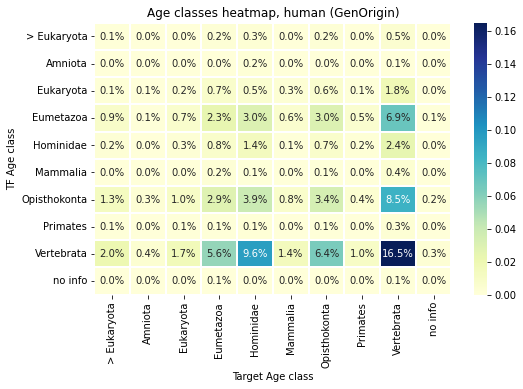

In [45]:
plt.rcParams["figure.figsize"] = 8, 5

x_axis_labels = ['> Eukaryota', 'Amniota', 'Eukaryota', 'Eumetazoa', 'Hominidae', 'Mammalia', 
                 'Opisthokonta', 'Primates','Vertebrata', 'no info']

y_axis_labels = ['> Eukaryota', 'Amniota', 'Eukaryota', 'Eumetazoa', 'Hominidae', 'Mammalia', 
                 'Opisthokonta', 'Primates','Vertebrata', 'no info']

s = sns.heatmap(heatmap_h,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".1%",
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
plt.title('Age classes heatmap, human (GenOrigin)')

#plt.savefig('../data/03_plots/human_heatmap_01.png')
#plt.close()

#### Tg/TF

In [155]:
ages_list = ['no info', '> Eukaryota', 'Eukaryota', 'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Amniota', 
            'Mammalia', 'Primates', 'Hominidae']

tf_tg_count = heatmap_h.copy()

for tf_age in ages_list:
    for tg_age in ages_list:
        new_table = human_data[(human_data.Tg_age == tg_age) & (human_data.Tf_age == tf_age)]
        
        if new_table[['TF']].nunique().iloc[0] != 0:
            new_value = new_table[['Target']].nunique().iloc[0] / new_table[['TF']].nunique().iloc[0]
        
        else:
            new_value = 0
        
        tf_tg_count.loc[tf_age, tg_age] = new_value

In [156]:
tf_tg_count

Tg_age,> Eukaryota,Amniota,Eukaryota,Eumetazoa,Hominidae,Mammalia,Opisthokonta,Primates,Vertebrata,no info
Tf_age,,,,,,,,,,
> Eukaryota,1.400000,1.000000,1.333333,2.000000,2.230769,1.333333,1.666667,1.000000,3.153846,1.000000
Amniota,1.000000,0.000000,0.000000,2.000000,2.142857,1.000000,1.000000,0.000000,1.666667,0.000000
Eukaryota,1.166667,1.000000,1.750000,2.103448,3.062500,1.928571,1.758621,1.200000,3.318182,1.000000
Eumetazoa,1.666667,1.333333,1.461538,2.219512,2.639535,1.410256,2.266667,1.678571,2.972603,1.090909
Hominidae,1.437500,1.000000,1.533333,2.481481,2.500000,1.100000,1.903226,1.214286,3.500000,1.000000
Mammalia,1.500000,1.000000,1.000000,2.000000,1.666667,1.333333,1.285714,1.500000,2.923077,1.000000
Opisthokonta,1.807018,1.315789,1.720000,2.411111,3.546512,1.320000,2.714286,1.576923,3.619355,1.272727
Primates,4.500000,1.000000,1.750000,1.000000,2.166667,1.000000,2.000000,1.500000,6.250000,3.000000
Vertebrata,2.151899,1.560000,1.769231,2.404908,3.408840,1.592105,2.687117,1.543860,3.123675,1.120000


In [157]:
tf_ages_count = human_data.groupby(['TF', 'Tf_age'], as_index=0).count().groupby('Tf_age', as_index=0).count()[['Tf_age', 'TF']]
tg_ages_count = human_data.groupby(['Target', 'Tg_age'], as_index=0).count().groupby('Tg_age', as_index=0).count()[['Tg_age', 'Target']]

Text(0.5, 1.0, 'TG/TF heatmap, human (GenOrigin)')

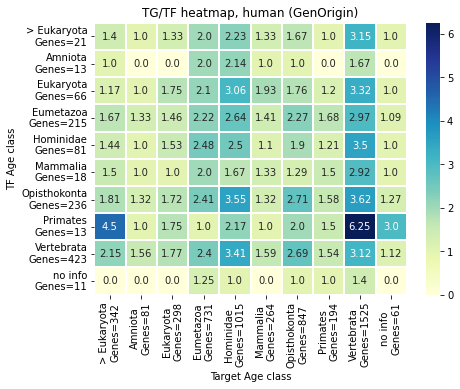

In [158]:
plt.rcParams["figure.figsize"] = 7, 5

xlabels = ['> Eukaryota', 'Amniota', 'Eukaryota', 'Eumetazoa', 'Hominidae', 'Mammalia', 
           'Opisthokonta', 'Primates','Vertebrata', 'no info']

ylabels = ['> Eukaryota', 'Amniota', 'Eukaryota', 'Eumetazoa', 'Hominidae', 'Mammalia', 
           'Opisthokonta', 'Primates','Vertebrata', 'no info']

x_axis_labels = []
y_axis_labels = []

for label in xlabels:
    x_axis_labels.append(f'{label}\nGenes={tg_ages_count[tg_ages_count.Tg_age == label].Target.iloc[0]}')
    
for label in ylabels:
    y_axis_labels.append(f'{label}\nGenes={tf_ages_count[tf_ages_count.Tf_age == label].TF.iloc[0]}')

s = sns.heatmap(tf_tg_count,
                xticklabels=x_axis_labels, 
                yticklabels=y_axis_labels,
                annot=True, 
                fmt=".3",
                cmap="YlGnBu",
                linewidths=1.5)

s.set(xlabel='Target Age class', ylabel='TF Age class')
plt.title('TG/TF heatmap, human (GenOrigin)')

#plt.savefig('../data/03_plots/human_heatmap_02.png')
#plt.close()

## 3.3. Edge "len"  <a name="human_len"></a>

In [46]:
classes = ['no info', '> Eukaryota', 'Eukaryota', 'Opisthokonta', 'Eumetazoa', 'Vertebrata', 'Amniota', 
           'Mammalia', 'Primates', 'Hominidae']

human_data['Tg_age'] = human_data['Tg_age'].apply(lambda x: classes.index(x))
human_data['Tf_age'] = human_data['Tf_age'].apply(lambda x: classes.index(x))

In [47]:
human_data['age_length'] = np.where((human_data['Tf_age'] == 0) | (human_data['Tg_age'] == 0),
                                     -1,
                                     abs(human_data['Tf_age'] - human_data['Tg_age']))

# no info to NAN
human_data['age_length'] = human_data['age_length'].replace({-1: np.nan})

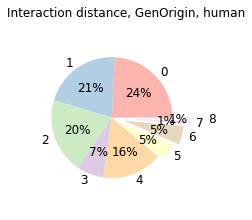

In [50]:
plt.rcParams["figure.figsize"] = 3, 3.5

idx = [0, 1, 2, 3, 4, 5, 6, 7, 8]
counts = pd.Series(human_data['age_length'].value_counts(normalize=True) * 100)
counts.index = counts.index.astype('int64')
counts = counts[idx]

explode = (0, 0, 0, 0, 0, 0.1, 0.2, 0.3, 0.5)
counts.plot(kind='pie', 
            fontsize=12, 
            colormap="Pastel1", 
            explode=explode,  
            autopct='%.0f%%')
plt.axis('equal')
plt.ylabel('')
plt.title('Interaction distance, GenOrigin, human')

plt.show()
#plt.savefig('../data/03_plots/human_len.png')
#plt.close()